In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math
from tqdm import tqdm

In [3]:
os.makedirs('../cleaned_data/splited_data', exist_ok=True)
os.makedirs('../cleaned_data/splited_data/test', exist_ok=True)
os.makedirs('../cleaned_data/splited_data/train', exist_ok=True)

In [4]:
check_in=pd.read_csv('../cleaned_data/filted_data/checkin.csv')

In [5]:
business=pd.read_csv('../cleaned_data/filted_data/business.csv')
tip=pd.read_csv('../cleaned_data/filted_data/tip.csv')
checkin=pd.read_csv('../cleaned_data/filted_data/checkin.csv')
user=pd.read_csv('../cleaned_data/filted_data/user.csv')


tip['date'] = pd.to_datetime(tip['date'])

for i in range(len(tip)):
    index=tip.index.values[i]
    tip.loc[index,'date']=tip.loc[index,'date'].timestamp()

In [6]:
len(tip)

29738

In [16]:
tip.head()

,user_id,business_id,text,date,compliment_count
0,j2sEA3hiUcwHfq9Ml6M47g,EXYbKA1tocvOK_1tXxZXLA,Don't go for dinner. They close at 6. Really Y...,1318475715.0,0
1,nZB33t0RFtq_jTxJJJ6wfA,RNzhLU8zy1L5dBkjRK4xEA,Best steak tartare ever,1290985789.0,0
2,9qZVikoJoqfQK9SBSynAGA,l-rGtJt0E7PAklT0IK7oFQ,Great atmosphere... Live music... Excellent dr...,1402721674.0,0
3,QVoOwjH06W-jYMjVh8hwIQ,SAQgO7Ij2cdnMp8VQKBffA,Try the Calamari!,1318088895.0,0
4,ezfjpyJ_XQO7aJp49T0aGg,qUH2FppY7RL96F5tXzA0hQ,"Nice service, good ambiance, delicious coffee ...",1432852645.0,0


In [8]:
import json

In [9]:
f = open('../cleaned_data/filted_data/review.json')
data = json.load(f)

In [24]:
print(f'type:{type(data)},\nkeys:{list(data.keys())},\ncolumns:{data["columns"]}')

type:<class 'dict'>,
keys:['columns', 'data'],
columns:['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']


In [26]:
df = pd.DataFrame(data['data'],columns =data['columns'])
df = df.astype({'date':'string'})
df['date'] = df['date'].str[:-3]
df = df.astype({'date':'int'})

**Select users whose reviews is over 5**

In [30]:
df=pd.concat([df, tip], ignore_index=True)
cou=df.groupby('user_id').count()
df['count']=cou['review_id']
cou[cou['review_id']>=5].index.values

array(['--17Db1K-KujRuN7hY9Z0Q', '-0-TtVhV4PIUoDpUCOC0uQ',
       '-0EcgtUXe1rzrkmdih_tYg', ..., 'zvs6DYpACuh0cpsPDO48dw',
       'zxAM0cdIbZZYN-6gVQuntQ', 'zyt0joW7uNeQof5tthQAHg'], dtype=object)

In [35]:
df = df[df['user_id'].isin(cou[cou['review_id']>=5].index.values)] 
cou=cou[cou['review_id']>=5]

In [34]:
def Specific_row(user_id, df):
    temp = df[df['user_id'] == user_id]
    index = math.floor(len(temp) * 0.8)
    temp = temp.sort_values(by=['date'], ascending=True)
    return temp.iloc[index, :]

df2 = pd.DataFrame(columns=df.columns)

for i in tqdm(range(len(cou)), desc="Processing rows"):
    new_row = Specific_row(cou.index.values[i], df)
    df2.loc[len(df2)] = new_row

Processing rows: 100%|██████████| 8003/8003 [02:03<00:00, 64.96it/s]


In [36]:
df2.to_csv('../cleaned_data/splited_data/filtered.csv')

<Axes: ylabel='Density'>

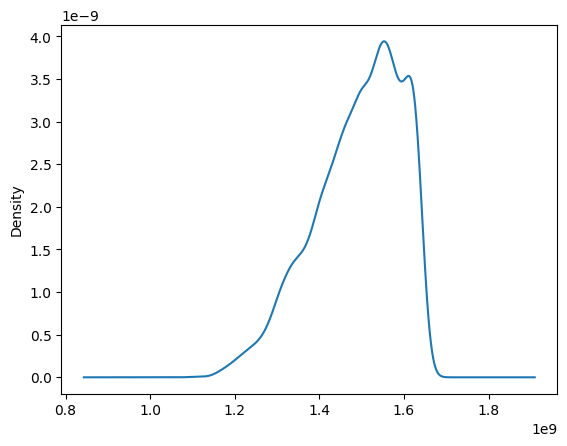

In [37]:
from datetime import datetime
import matplotlib.pyplot as plt
df2=pd.read_csv('../cleaned_data/splited_data/filtered.csv')
df2['date'].plot(kind='kde')

**Split data set by date**

In [38]:
train=df[df['date']<df2['date'].mean()]
test=df[df['date']>df2['date'].mean()]

In [39]:
test = test[test['user_id'].isin(set(train['user_id'].values))] 
test = test[test['business_id'].isin(set(train['business_id'].values))] 

In [40]:
df2['date'].mean()

1491706958.2587779

In [41]:
from datetime import datetime
df2['date2'] = [datetime.fromtimestamp(x) for x in df2['date']]

**Import Figure**

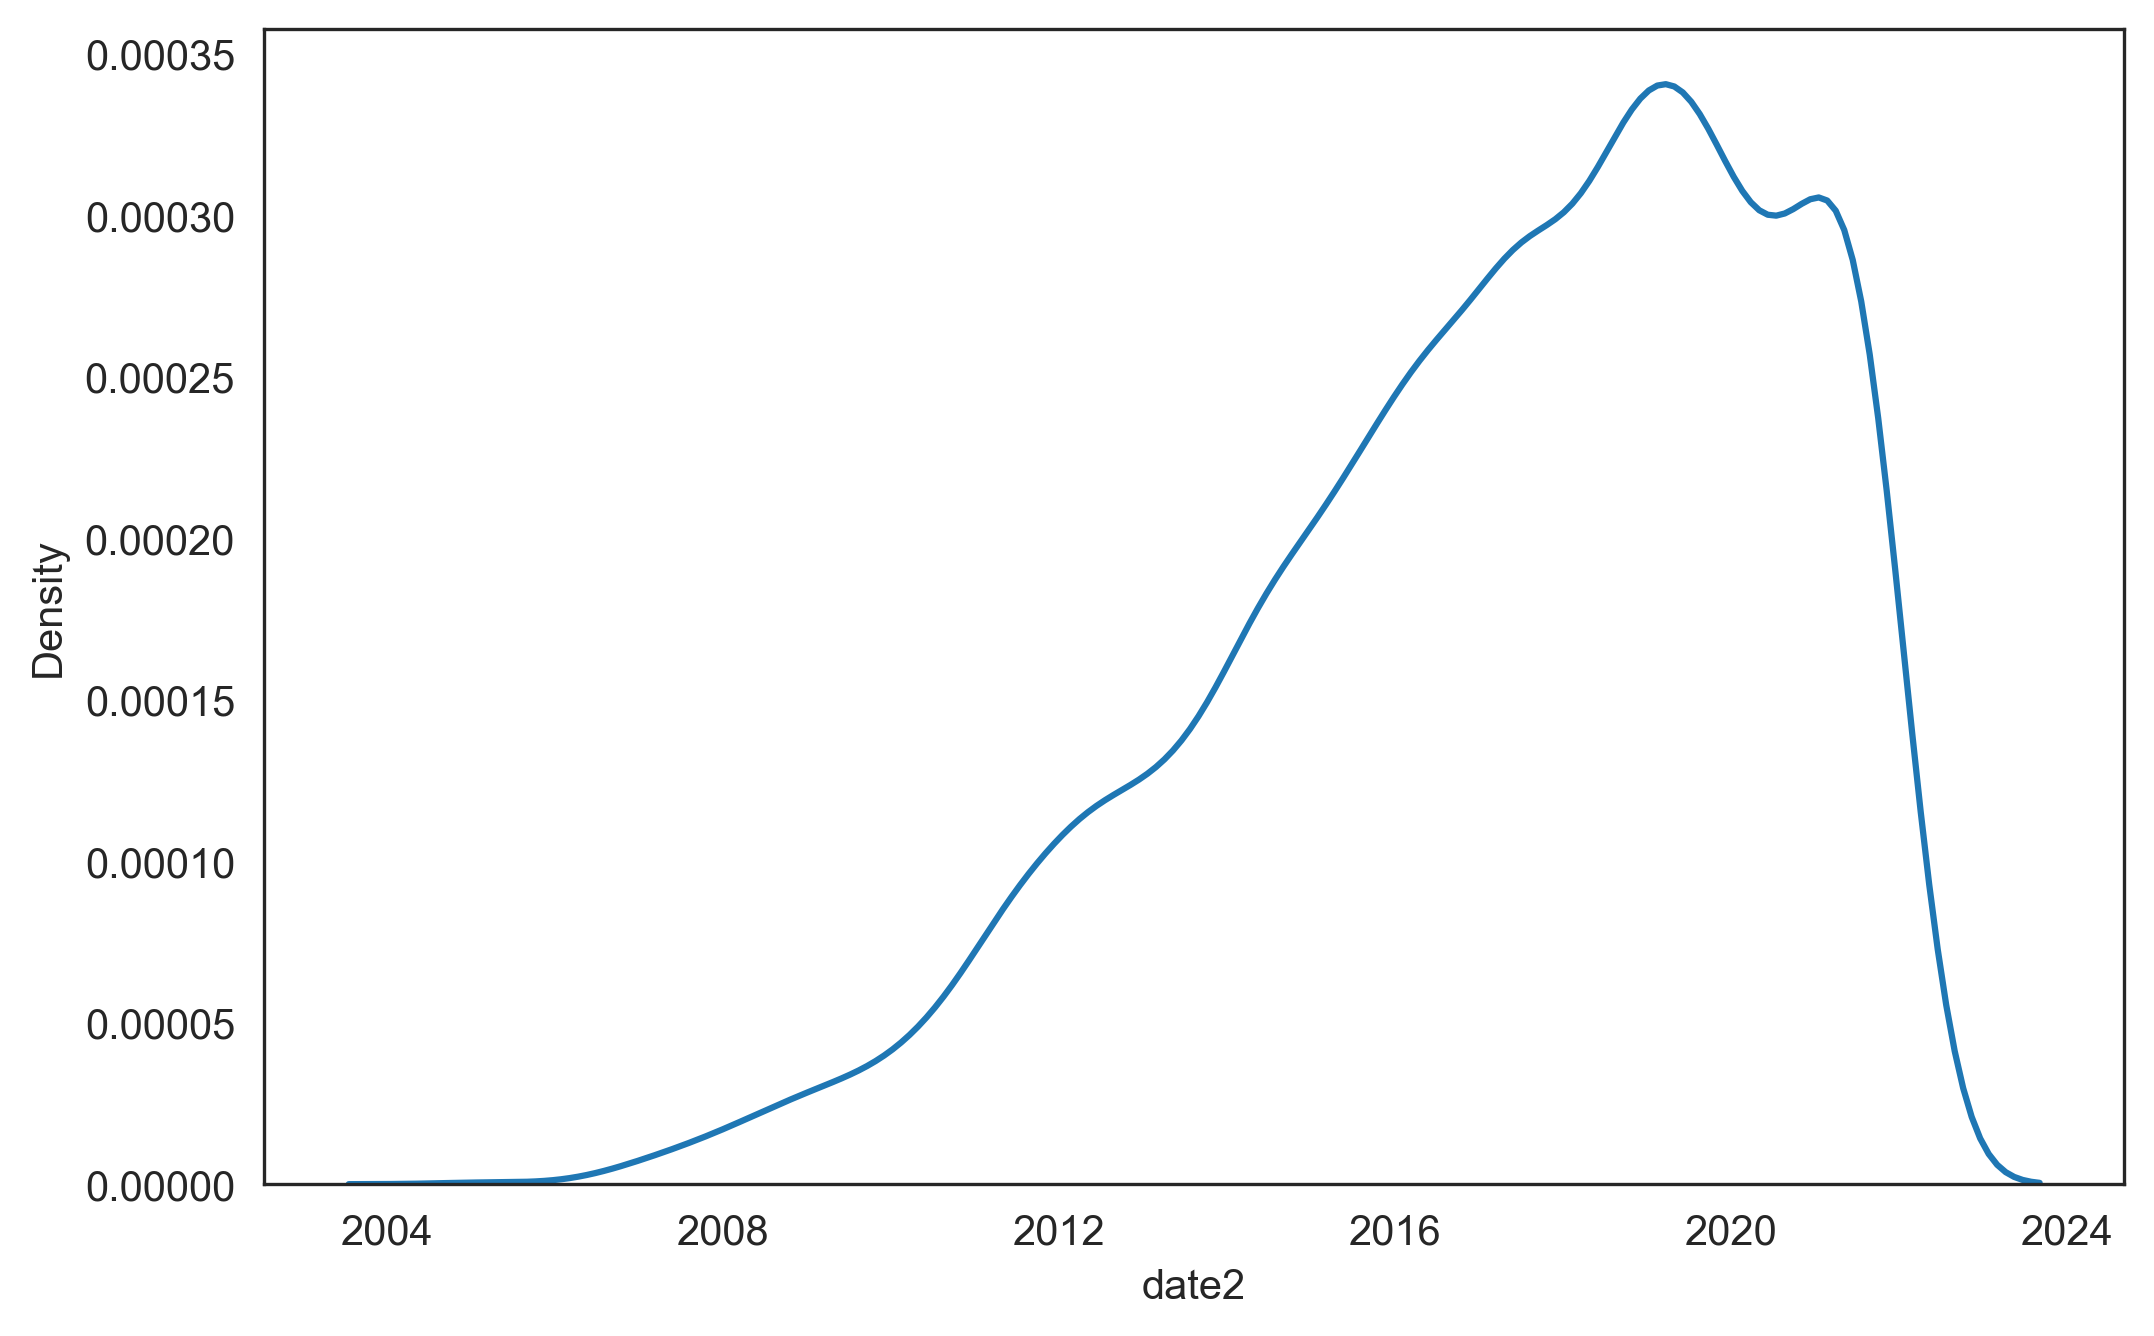

In [43]:
import seaborn as sns
plt.rcParams["figure.dpi"] = 300
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(df2['date2'],ax=ax)
plt.savefig('distribution')

In [44]:
df2['date2'].head()

0   2017-10-14 09:39:03
1   2020-11-19 12:22:50
2   2018-07-14 03:50:55
3   2013-11-20 03:38:50
4   2019-10-26 02:28:13
Name: date2, dtype: datetime64[ns]

In [45]:
len(test)

18227

In [46]:
len(train)

78640

In [ ]:
train.to_json("../cleaned_data/splited_data/train/review_train.json", orient="split", index=False)
test.to_json("../cleaned_data/splited_data/test/review_test.json", orient="split", index=False)
business=business[business['business_id'].isin(set(train['business_id'].values))] 

In [49]:
tip=tip[tip['business_id'].isin(set(train['business_id'].values))]
tip=tip[tip['user_id'].isin(set(train['user_id'].values))]
user=user[user['user_id'].isin(set(train['user_id'].values))]
check_in=check_in[check_in['business_id'].isin(set(train['business_id'].values))]

In [50]:
business.to_csv('../cleaned_data/splited_data/train/new_business.csv')
check_in.to_csv('../cleaned_data/splited_data/train/new_check_in.csv')
tip.to_csv('../cleaned_data/splited_data/train/new_tip.csv')
user.to_csv('../cleaned_data/splited_data/train/new_user.csv')

In [51]:
total=pd.concat([train,test])
total.to_csv('../cleaned_data/splited_data/new_total.csv')